# Assignment 3 Data Analysis via Pandas

Get an experimentally informed connection matrix from from http://hippocampome.org/netlist
Or an excell spreadsheet of similar origin.

https://collab.humanbrainproject.eu/#/collab/5458/nav/42545


In [1]:
import os
import pandas as pd


# Perform some system admin

import os
import pandas as pd
import sys
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update({'font.size':16})
installs = ['neuron','mpi4py','xlrd','pyNN','seaborn','lazyarray','neo','neuron','brian2']
def install_deps(i):
  '''
  Hack in dependencies to sys.path
  '''
  import os
  if i not in sys.path:
    os.system('pip install '+str(i))    

_ = list(map(install_deps,installs))
#import lazyarray
#import pyNN
import os
import pandas as pd



# Get some hippocampus connectivity data, based on a conversation with
# academic researchers on GH:
# https://github.com/Hippocampome-Org/GraphTheory/issues?q=is%3Aissue+is%3Aclosed
# scrape hippocamome connectivity data, that I intend to use to program neuromorphic hardware.
# conditionally get files if they don't exist.


# This connection matrix is not very informative, because it only tells you about connections dissociated From
# a stable list of cellular entities.
# path = 'netlist'
# if not os.path.exists(path):
#     os.system('wget http://hippocampome.org/netlist')
# nldf = pd.read_csv('netlist',delimiter=',').dropna()

path_xl = '_hybrid_connectivity_matrix_20171103_092033.xlsx'
if not os.path.exists(path_xl):
    os.system('wget https://github.com/Hippocampome-Org/GraphTheory/files/1657258/_hybrid_connectivity_matrix_20171103_092033.xlsx')

xl = pd.ExcelFile(path_xl)
dfEE = xl.parse()
dfEE.loc[0].keys()


import matplotlib.pyplot as plt
dfm = dfEE.as_matrix()



In [2]:

filtered = dfm[:,3:]
filtered = filtered[1:]
print(filtered[1:])

[[1 0 1 ..., 0 0 0]
 [1 1 2 ..., 0 0 0]
 [1 1 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., -1 -1 -1]
 [0 0 0 ..., -1 -1 -1]
 [0 0 0 ..., -1 -1 -1]]


In [3]:

import numpy as np
from pyNN.neuron import STDPMechanism
import copy
print(dfm)
EElist = []
IIlist = []
for i,j in enumerate(filtered):
  for k,xaxis in enumerate(j):
    if xaxis==1 or xaxis ==2:
      source = i
      target = k
      delay = 0.0
      weight = 0.1
      EElist.append((source,target,delay,weight))
        
    if xaxis==-1 or xaxis ==-2:
      source = i
      target = k
      delay = 0.0
      weight = 0.1
      IIlist.append((source,target,delay,weight))     
import matplotlib 
matplotlib.pyplot.imshow

ml = len(filtered[1])+1
plot_excit = np.zeros(shape=(ml,ml))
plot_inhib = np.zeros(shape=(ml,ml))
pre_exc = []
post_exc = []
pre_inh = []
post_inh = []
print(np.shape(plot_excit))
for i in EElist:
    plot_excit[i[0],i[1]]=1
    pre_exc.append(i[0])
    post_exc.append(i[1])
for i in IIlist:
    plot_inhib[i[0],i[1]]=1
    pre_inh.append(i[0])
    post_inh.append(i[1])

 
    

[['↓' 'UniqueID' 1000 ..., 6040 6087 6038]
 ['DG: Granule (+)2201p' 1000 0 ..., 0 0 0]
 ['DG: Hilar Ectopic Granule (+)2203p' 1041 0 ..., 0 0 0]
 ..., 
 ['EC: MEC LIII Superficial MPI (-)233000' 6040 0 ..., -1 -1 -1]
 ['EC: LIII Pyramidal-Looking (-)023300' 6087 0 ..., -1 -1 -1]
 ['EC: MEC LIII Superficial Trilayer (-)333000' 6038 0 ..., -1 -1 -1]]
(122, 122)


In [4]:

index_exc = [ i for i,d in enumerate(dfm) if '+' in d[0] ]
import pyNN.neuron as neuron
index_inh = [ i for i,d in enumerate(dfm) if '-' in d[0] ]
pop_exc = neuron.Population(len(index_exc), neuron.Izhikevich(i_offset=0))
pop_inh = neuron.Population(len(index_inh), neuron.Izhikevich(i_offset=0))


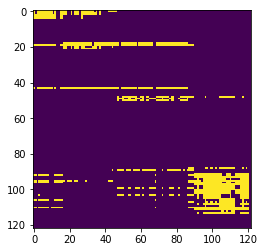

In [5]:
matplotlib.pyplot.imshow(plot_excit)   

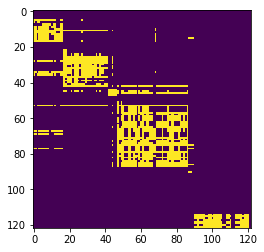

In [6]:
matplotlib.pyplot.imshow(plot_inhib)   

In [7]:
import pyNN
from pyNN.random import RandomDistribution, NumpyRNG

from pyNN.neuron import STDPMechanism, SpikePairRule, AdditiveWeightDependence, FromListConnector, TsodyksMarkramSynapse
#from pyNN.neuron import RandomDistribution
from pyNN.neuron import Projection

rng = NumpyRNG(seed=64754)
#sparse_connectivity = FixedProbabilityConnector(0.1, rng=rng)


#weight_distr = RandomDistribution('normal', [0.01, 1e-3], rng=rng)
#facilitating = TsodyksMarkramSynapse(U=0.04, tau_rec=100.0, tau_facil=1000.0,
#                                     weight=weight_distr, delay=lambda d: 0.1+d/100.0)

connector = FromListConnector(IIlist, column_names=["weight", "delay"])
pop = neuron.Population(len(index_exc)+len(index_inh), neuron.Izhikevich(i_offset=0))

#pop_inh = neuron.Population(len(index_inh), neuron.Izhikevich(i_offset=0))

inhib_connections = Projection(pop, pop, connector,
                                    facilitating)


print(len(IIlist),len(pop_inh))
print(dir(connector))
print(connector.conn_list)
print(connector.column_names)


NameError: name 'facilitating' is not defined

In [ ]:

stdp = STDPMechanism(
          weight=0.02,  # this is the initial value of the weight
          delay="0.2 + 0.01*d",
          timing_dependence=SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                          A_plus=0.01, A_minus=0.012),
          weight_dependence=AdditiveWeightDependence(w_min=0, w_max=0.04))

connector = FromListConnector(EElist, column_names=["weight", "delay"])
excitatory_connections = Projection(pop, pop, connector,
                                    stdp)



In [ ]:
print(II)
import pandas as pd
#dfEE =  pd.DataFrame([ (k,v) for k,v in df.items() if 'EC' in k ])

import numpy as np
np.shape(dfEE)

print(dfEE.keys())

In [ ]:
#print(matrix)
#sns.pairplot(df, hue="species")
from scipy.sparse import coo_matrix
m = np.matrix(matrix)
if not isinstance(matrix, coo_matrix):
    m = coo_matrix(m)
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='black')
ax.plot(m.col, m.row, 's', color='white', ms=1)
ax.set_xlim(0, m.shape[1])
ax.set_ylim(0, m.shape[0])
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.figure.show()

#fig.show()
#plt.show()

#print(m)

#import seaborn as sns

#sns.set(style="ticks")

#df = sns.load_dataset("iris")
#sns.pairplot(m, hue="species")
#print(matrix[1][0])
#print(m[0])

Below are plots of post synaptic targets in the from an arbitary source cell in the Entorhinal cortex, to targets taht are also in the EC.

In [ ]:
#m
#print(plt.backend)
ax.figure.show()
fig.savefig('connection_matrix.png')
from IPython.display import Image
Image(filename='connection_matrix.png') 
#df
#targets
#pd.DataFrame(targets).plot.hist()
#for k,v in targets.items():
#  pd.DataFrame(v).plot.hist()
#df

In [ ]:
Image(filename='connection_matrix.png') 


In [ ]:
!pip install neuron

In [ ]:
from pyNN import neuron as p
#p.setup(1.0)
p.setup(timestep=1.0, min_delay=1.0)

#cell_params = {'cm': 0.25, 'tau_m': 10.0, 'tau_refrac': 2.0, 'tau_syn_E': 2.5, 'tau_syn_I': 2.5, 'v_reset': -70.0, 'v_rest': -65.0, 'v_thresh': -55.0 }
#cell_params = {'a':0.1779222, 'b':-5e-09, 'c':-59.52801, 'd':0.1531787, v_init=-'73.32355','i_offset':0}#, u_init, i_offset}

#pop = p.Population(NETSIZE, p.IF_curr_exp(i_offset=0))
neuron_type = p.Izhikevich()#cell_params)
pop = p.Population(NETSIZE, neuron_type)
#for ind in pop:
print(p.connect)

pop.record("spikes")
p.run(100)
pop.set(i_offset=1.0)
p.run(100)
pop.set(i_offset=0.0)
p.run(100)
spikes = pop.get_data("spikes")
p.end()


#p.setup(1.0)
#pop = sim.Population(100, sim.IZKCurrExp(cell_params))

print(spikes)

In [ ]:

#nldf['From']

#nldf.index('Granule')
#df = nldf[nldf['Name']==3]


#you'll likely need a user for authentication
#user = 'gevaert'
#server = 'http://localhost:8888'
#from bbp_client.oidc.client import BBPOIDCClient
#client = BBPOIDCClient.implicit_auth(user)
#from bbp_client.task_service.client import Client
#ts = Client(server, client)
#ts.get_tasks()
#bbp_client.register_task()
#bbp_client.start_job()



```
# This is formatted as code
```

